# Open Notebook directly in Google Colab:

<a target="_blank" href="https://colab.research.google.com/github/Nicolepcx/Oxford_multi_agent_investment_analysis/blob/main/lats_advice.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Language Agent Tree Search

[Language Agent Tree Search](https://arxiv.org/abs/2310.04406) (LATS), by Zhou, et. al, is a general LLM agent search algorithm that combines reflection/evaluation and search (specifically monte-carlo trees search) to get achieve better overall task performance compared to similar techniques like ReACT, Reflexion, or Tree of Thoughts.

![Graph](https://drive.google.com/uc?export=view&id=1u-zq_WQcuY6FlPB7-VJDCywix45P2W2J)

It has four main steps:

1. Select: pick the best next actions based on the aggregate rewards from step (2). Either respond (if a solution is found or the max search depth is reached) or continue searching.
2. Expand and simulate: select the "best" 5 potential actions to take and execute them in parallel.
3. Reflect + Evaluate: observe the outcomes of these actions and score the decisions based on reflection (and possibly external feedback)
4. Backpropagate: update the scores of the root trajectories based on the outcomes.

**First Framework Incorporating Reasoning, Acting, and Planning to Enhance LM Performance. LATS integrates Monte Carlo Tree Search (MCTS) with LMs to unify reasoning, acting, and planning.**

<br>

__Key Features:__
- LM-based value functions (replaces traditional RL-trained evaluators, leveraging in-context learning)
- Self-reflections for exploration
External feedback for adaptive problem-solving
<br><br>


LATS can be extended to interact with other agents, where each agent:
Represents a different trading strategy or trading signal (e.g., momentum-based, mean reversion, volatility-based).
Outputs possible actions based on its observations and logic.
The tree search can then evaluate these agent-generated strategies to determine the optimal path or combination of strategies.

LATS is highly compatible with reinforcement learning (RL):
Nodes in the tree can represent states in a trading environment.
Branches represent actions, such as going long, short, or hedging positions.

Agents can learn from the results of past searches and adjust their strategies, continuously improving through feedback.

## __LATS__

__Core Concept:__

LATS Framework: Combines Monte Carlo Tree Search (MCTS) with language models (LMs) to enable flexible and adaptive problem-solving for reasoning, acting, and planning tasks.

__Key Features:__

Integrates external feedback and self-reflection for iterative learning and improvement.
Synergizes reasoning and decision-making strategies, expanding ReAct into a search over a combinatorial space of reasoning and acting steps.

__Integration with Language Models:__

Repurposes pretrained LMs as agents, state evaluators, and feedback generators without requiring additional training.
Uses an LM-based value function to guide decision-making by evaluating states and actions in the MCTS framework.

__LM-Powered Value Function:__

LATS introduces a novel value function tailored for language agents:
Self-generated LM score: Evaluates the quality of states and actions directly using the language model.

__Self-consistency score:__

Assesses the reliability of reasoning across multiple trajectories or iterations.
This value function replaces traditional RL-trained evaluators, leveraging in-context learning instead of costly training processes.

__Planning and Search:__

LATS employs MCTS to construct the optimal trajectory from sampled actions, balancing exploration (new paths) and exploitation (promising paths).
Nodes in the decision tree represent states that combine the original input, action sequences, and environmental observations. Uses UCT (Upper Confidence bounds for Trees) to select the most promising states for expansion.

__Advantages:__
Unlike traditional methods (e.g., BFS, RAP), LATS leverages environmental feedback and integrates external observations without relying on pre-trained world models. Enhances reasoning by integrating self-refinement and self-consistency heuristics. Avoids expensive training by utilizing in-context learning for evaluation.

__Applications:__
Suitable for tasks requiring reasoning, planning, and interaction with external environments. Supports iterative refinement and robust decision-making, storing decision trees in long-term memory for further optimization.


__Comparison to Existing Methods:__
Improves upon ReAct, Reflexion, RAP, and ToT by incorporating structured search mechanisms with LM-based value functions and feedback. Overcomes the limitation of LMs failing to self-correct internal reasoning by integrating external input for refinement.


# Dependencies

Install `langgraph` (for the framework), `langchain_openai` (for the LLM), and `langchain` + `tavily-python` (for the search engine).

We will use tavily search as a tool. You can get an API key [here](https://app.tavily.com/sign-in) or replace with a different tool of your choosing.

In [ ]:
!pip install langchain langgraph langchain_openai langchain_core -qqq
!pip install tavily-python langchain_community python-dotenv -qqq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.7/412.7 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 3.9 MB/s eta 0:00:00


# Imports

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os
import math
import json
from collections import deque, defaultdict
from typing import Optional, List
from typing_extensions import TypedDict

from IPython.display import Image

from langchain_openai import ChatOpenAI

from langchain_core.output_parsers.openai_tools import (
    JsonOutputToolsParser,
    PydanticToolsParser,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.runnables import chain as as_runnable
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, ToolMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langgraph.prebuilt.tool_executor import ToolExecutor, ToolInvocation
from langchain_core.prompt_values import ChatPromptValue
from langchain_core.runnables import RunnableConfig


from dotenv import load_dotenv
load_dotenv()




/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


True

In [ ]:
# API-Access

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
TAVILY_API_KEY = os.getenv('TAVILY_API_KEY')

# Init LLM

In [ ]:
llm = ChatOpenAI(model="gpt-4o")

# Graph State

LATS is based on a (greedy) Monte-Carlo tree search. For each search steps, it picks the node with the highest "upper confidence bound", which is a metric that balances exploitation (highest average reward) and exploration (lowest visits). Starting from that node, it generates N (5 in this case) new candidate actions to take, and adds them to the tree. It stops searching either when it has generated a valid solution OR when it has reached the maximum number of rollouts (search tree depth).

Your LangGraph state will be composed of two items:
1. The root of the search tree
2. The user input

## Monte Carlo Tree Search

__Selection:__ Start from the root node and traverse the tree to select a node based on the Upper Confidence Bound applied to Trees (UCT).

__Expansion:__ If the selected node is not terminal, expand by generating child nodes from possible actions.

__Simulation:__ Run a random simulation from the new node to estimate a value.

__Backpropagation:__ Propagate the simulation results back up the tree, updating node values along the way.

__Reflection:__ When a trajectory fails, use feedback or self-reflection to adjust future decisions, refining the search by avoiding repeated mistakes and improving strategy.

## Reflection

The reflection chain will score agent outputs based on the decision and the tool responses.
We will call this within the other two nodes.

In [ ]:
class Reflection(BaseModel):
    reflections: str = Field(
        description="The critique and reflections on the sufficiency, superfluency, and general quality of the response."
    )
    score: int = Field(
        description="Score from 0-10 on the quality of the candidate response.",
        gte=0,
        lte=10,
    )
    found_solution: bool = Field(
        description="Whether the response has fully solved the question or task."
    )

    def as_message(self):
        reasoning_message = f"Reasoning: {self.reflections}\nScore: {self.score}\nFound Solution: {self.found_solution}"
        print(reasoning_message)  # Print reasoning steps
        return HumanMessage(content=reasoning_message)


    @property
    def normalized_score(self) -> float:
        """Return a normalized score between 0 and 1."""
        return self.score / 10.0

    @classmethod
    def from_response(cls, tool_choices, inputs):
        """Initialize Reflection instance directly from parsed tool response."""
        reflection = tool_choices[0]
        if not isinstance(inputs["candidate"][-1], AIMessage):
            reflection.found_solution = False
        return reflection


# Configure Prompt Template for Reflection
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Reflect and grade the assistant response to the user question below.",
        ),
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="candidate"),
    ]
)

# Reflection Chain Construction
reflection_llm_chain = (
    prompt
    | llm.bind_tools(tools=[Reflection], tool_choice="Reflection").with_config(
        run_name="Reflection"
    )
    | PydanticToolsParser(tools=[Reflection])
)

@as_runnable
def reflection_chain(inputs) -> Reflection:
    tool_choices = reflection_llm_chain.invoke(inputs)
    reflection = Reflection.from_response(tool_choices, inputs)
    print(f"Reflection for input: {inputs['input']}\n"
          f"Critique: {reflection.reflections}\n"
          f"Score: {reflection.score}\n"
          f"Found Solution: {reflection.found_solution}\n")
    return reflection



## Upper Confidence bounds Applied to Trees (UCT)

The value for expansion is selected by the next iteration. The UCT of a child state $s$ is calculated as follows:


$$
\operatorname{UCT}(s)=V(s)+c \sqrt{\frac{\ln N(p)}{N(s)}},
$$

where:
- $V(s)$: Value estimate of node $s$
- N(s): Visit count of node $s$
- N(p): Visit count of parent node
- c: Exploration weight


## Backpropagation in LATS

The return $r$ is used for updating every $V(s)$ along the path with the formula:

$V(s)=\frac{V_{{old}} (s)(N(s)-1)+r}{N(s)},$

where $V_{old}(s)$ is the old value function.


In [ ]:
class Node:
    __slots__ = (
        "messages", "parent", "children", "value", "visits", "reflection", "depth",
        "_is_solved"
    )

    def __init__(
        self,
        messages: List[BaseMessage],
        reflection: 'Reflection',
        parent: Optional["Node"] = None,
    ):
        self.messages = messages
        self.parent = parent
        self.children = []
        self.value = 0
        self.visits = 0
        self.reflection = reflection
        self.depth = parent.depth + 1 if parent is not None else 1
        self._is_solved = reflection.found_solution if reflection else False
        if self._is_solved:
            self._mark_tree_as_solved()
        self.backpropagate(reflection.normalized_score)

    def __repr__(self) -> str:
        return (
            f"<Node value={self.value}, visits={self.visits},"
            f" solution={self.messages} reflection={self.reflection}/>"
        )

    @property
    def is_solved(self):
        return self._is_solved

    @property
    def is_terminal(self):
        return not self.children

    @property
    def best_child(self):
        if not self.children:
            return None
        return max(self.children, key=lambda child: child.upper_confidence_bound())

    @property
    def best_child_score(self):
        if not self.children:
            return None
        return max(self.children, key=lambda child: int(child.is_solved) * child.value)

    @property
    def height(self) -> int:
        if self.children:
            return 1 + max(child.height for child in self.children)
        return 1

    def upper_confidence_bound(self, exploration_weight=1.0):
        if self.parent is None:
            raise ValueError("Cannot obtain UCT from root node")
        if self.visits == 0:
            return self.value
        average_reward = self.value / self.visits
        exploration_term = math.sqrt(math.log(self.parent.visits) / self.visits)
        return average_reward + exploration_weight * exploration_term

    def backpropagate(self, reward: float):
        node = self
        while node:
            node.visits += 1
            node.value = (node.value * (node.visits - 1) + reward) / node.visits
            node = node.parent

    def get_messages(self, include_reflections: bool = True):
        if include_reflections:
            return self.messages + [self.reflection.as_message()]
        return self.messages

    def get_trajectory(self, include_reflections: bool = True) -> List[BaseMessage]:
        messages = []
        node = self
        while node:
            step_messages = node.get_messages(include_reflections=include_reflections)[::-1]
            messages.extend(step_messages)
            print(f"Step at depth {node.depth}:")
            for msg in step_messages:
                print(msg.content)  # Print reasoning at each step
            print("-----------")
            node = node.parent
        return messages[::-1]


    def _get_all_children(self):
        all_nodes = []
        nodes = deque([self])
        while nodes:
            node = nodes.popleft()
            all_nodes.extend(node.children)
            nodes.extend(node.children)
        return all_nodes

    def get_best_solution(self):
        all_nodes = [self] + self._get_all_children()
        best_node = max(
            all_nodes,
            key=lambda node: int(node.is_terminal and node.is_solved) * node.value,
        )
        return best_node

    def _mark_tree_as_solved(self):
        parent = self.parent
        while parent:
            parent._is_solved = True
            parent = parent.parent


#### The graph state itself

The main component is the tree, represented by the root node.

In [ ]:
class TreeState(TypedDict):
    # The full tree
    root: Node
    # The original input
    input: str

# Define Language Agent

Our agent will have three primary LLM-powered processes:
1. Reflect: score the action based on the tool response.
2. Initial response: to create the root node and start the search.
3. Expand: generate 5 candidate "next steps" from the best spot in the current tree

For more "Grounded" tool applications (such as code synthesis), you could integrate code execution into the reflection/reward step. This type of external feedback is very useful (though adds complexity to an already complicated example notebook).

#### Tools

For our example, we will give the language agent a search engine.

In [ ]:
search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=search, max_results=5)
tools = [tavily_tool]
tool_executor = ToolExecutor(tools=tools)

## Initial Response

We start with a single root node, generated by this first step. It responds to the user input either with a tool invocation or a response.

In [ ]:
prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an AI assistant.",
        ),
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)


initial_answer_chain = prompt_template | llm.bind_tools(tools=tools).with_config(
    run_name="GenerateInitialCandidate"
)


parser = JsonOutputToolsParser(return_id=True)

### Starting Node

We will package up the candidate generation and reflection in a single node of our graph. This is represented by the following function:

In [ ]:
# Define the node we will add to the graph
def generate_initial_response(state: TreeState) -> dict:
    """Generate the initial candidate response."""
    res = initial_answer_chain.invoke({"input": state["input"]})
    parsed = parser.invoke(res)
    tool_responses = tool_executor.batch(
        [ToolInvocation(tool=r["type"], tool_input=r["args"]) for r in parsed]
    )
    output_messages = [res] + [
        ToolMessage(content=json.dumps(resp), tool_call_id=tool_call["id"])
        for resp, tool_call in zip(tool_responses, parsed)
    ]
    reflection = reflection_chain.invoke(
        {"input": state["input"], "candidate": output_messages}
    )
    root = Node(output_messages, reflection=reflection)
    return {
        **state,
        "root": root,
    }

## Candidate Generation

The following code prompts the same LLM to generate N additional candidates to check.

In [ ]:
def expand(state: TreeState, config: RunnableConfig) -> dict:
    """Starting from the "best" node in the tree, generate N candidates for the next step."""
    root = state["root"]
    best_candidate: Node = root.best_child if root.children else root
    messages = best_candidate.get_trajectory()
    # Generate N candidates from the single child candidate
    new_candidates = expansion_chain.invoke(
        {"input": state["input"], "messages": messages}, config
    )
    parsed = parser.batch(new_candidates)
    flattened = [
        (i, tool_call)
        for i, tool_calls in enumerate(parsed)
        for tool_call in tool_calls
    ]
    tool_responses = tool_executor.batch(
        [
            ToolInvocation(tool=tool_call["type"], tool_input=tool_call["args"])
            for _, tool_call in flattened
        ]
    )
    collected_responses = defaultdict(list)
    for (i, tool_call), resp in zip(flattened, tool_responses):
        collected_responses[i].append(
            ToolMessage(content=json.dumps(resp), tool_call_id=tool_call["id"])
        )
    output_messages = []
    for i, candidate in enumerate(new_candidates):
        output_messages.append([candidate] + collected_responses[i])

    # Reflect on each candidate
    # For tasks with external validation, you can add it here
    reflections = reflection_chain.batch(
        [{"input": state["input"], "candidate": msges} for msges in output_messages],
        config,
    )
    # Grow tree
    child_nodes = [
        Node(cand, parent=best_candidate, reflection=reflection)
        for cand, reflection in zip(output_messages, reflections)
    ]
    best_candidate.children.extend(child_nodes)
    # We have already extended the tree directly, so we just return the state
    return state

In [ ]:
# Centralized Configuration for LATS with MCTS
config = {
    "candidate_count": 5,  # N - Number of candidate generations
    "max_depth": 5,        # Max rollout depth for tree search
}

# Generate Candidates with Centralized Configuration
def generate_candidates(messages: ChatPromptValue, config: RunnableConfig):
    n = config.get("candidate_count", 5)  # Retrieve from centralized config
    bound_kwargs = llm.bind_tools(tools=tools).kwargs

    # Generate candidates with preconfigured settings
    chat_result = llm.generate(
        [messages.to_messages()],
        n=n,
        callbacks=config["callbacks"],
        run_name="GenerateCandidates",
        **bound_kwargs,
    )
    return [gen.message for gen in chat_result.generations[0]]

# Build the StateGraph for MCTS with Centralized Depth Control
from typing import Literal
from langgraph.graph import END, StateGraph, START

def should_loop(state: TreeState) -> Literal["expand", "__end__"]:
    """Determine whether to continue the tree search based on centralized config."""
    root = state["root"]
    if root.is_solved:
        return END
    if root.height > config["max_depth"]:  # Use centralized depth limit
        return END
    return "expand"

# Initialize the StateGraph with Tree Nodes
builder = StateGraph(TreeState)
builder.add_node("start", generate_initial_response)
builder.add_node("expand", expand)
builder.add_edge(START, "start")

# Set conditional edges based on should_loop function
builder.add_conditional_edges("start", should_loop)
builder.add_conditional_edges("expand", should_loop)

# Compile the graph
graph = builder.compile()

# Usage of expansion chain with centralized configuration
expansion_chain = prompt_template | generate_candidates


#### Candidate generation node

We will package the candidate generation and reflection steps in the following "expand" node.
We do all the operations as a batch process to speed up execution.

## Plot Graph

With those two nodes defined, we are ready to define the graph. After each agent step, we have the option of finishing.

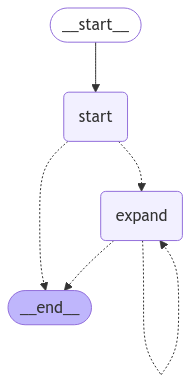

In [ ]:
Image(graph.get_graph().draw_mermaid_png())

#  Run LATS

In [ ]:
def run_lats(graph, question: str):
    """
    Executes the graph query with the provided question, streams the results,
    and retrieves the best solution's trajectory.

    Parameters:
    - graph: The LangGraph StateGraph instance.
    - question (str): The query or prompt to feed into the graph.

    Returns:
    - str: The content of the best trajectory's final message.
    """
    last_step = None
    for step in graph.stream({"input": question}):
        last_step = step
        step_name, step_state = next(iter(step.items()))
        print(f"Step: {step_name}")
        print(f"Tree rolled out: {step_state['root'].height}")
        print("---")

    if last_step and "expand" in last_step:
        solution_node = last_step["expand"]["root"].get_best_solution()
        best_trajectory = solution_node.get_trajectory(include_reflections=True)  # Include reflections
        print("\nBest Solution Reasoning Steps:")
        for msg in best_trajectory:
            print(msg.content)
        return best_trajectory[-1].content
    else:
        print("No solution found or graph did not expand as expected.")
        return None


In [ ]:
question = """
            Look up the revenue growth and risk factors of Uber and Lyft,
            which company is performing better? Please use concrete numbers to inform your decision.
            """
best_solution_content = run_lats(graph, question)
if best_solution_content:
    print("Best solution content:", best_solution_content)


Reflection for input: 
            Look up the revenue growth and risk factors of Uber and Lyft, 
            which company is performing better? Please use concrete numbers to inform your decision.
            
Critique: The response provided partially addresses the user's question by offering relevant data about the revenue growth of Uber and Lyft. However, it fails to directly compare these companies using specific 2023 figures or provide a definitive conclusion on which company is performing better overall, as requested. 

The data collected shows Uber's revenue growth at 17% in 2023 with a total annual revenue of $37.3 billion, while Lyft's revenue growth is reported at 7.53% for the same year, with an annual revenue of $4.40 billion. However, regarding risk factors, although some documents from the companies' filings such as 10-K reports are referenced, the specific risks impacting each company and how they differ are not clearly outlined. This makes it hard for the user to under